# import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

from sklearn.cluster import KMeans
from sklearn.ensemble import (
    RandomForestClassifier, 
    StackingClassifier,
    VotingClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Preprocessing Data

### prepare data

In [3]:
# phenotype.txt dataframe -> dataframe
data = pd.read_csv('phenotype.txt', sep="\t")
# data.head()

In [4]:
data.shape

(16955, 66)

### missing value process

In [5]:
missing_data = data.isna().sum()
missing_data = missing_data[missing_data > 0]
missing_data

SMOK_B             177
SMOKA_MOD_B       5950
ALCO_B             577
ALCO_AMOUNT_B     1450
EXER_B            1199
MDM_B            16262
MHTN_B           15002
MLPD_B           16516
PHTN_B           14602
PDM_B            15980
PLPD_B           16251
HT_B                34
WT_B                35
WAIST_B            832
SBP_B              223
DBP_B              223
CHO_B               56
LDL_B              165
TG_B               137
HDL_B              260
FBS_B               40
GOT_B               53
GPT_B               53
GGT_B              110
URIC_B            1403
PCAN80           16916
PCAN81           16768
PCAN82           16943
PCAN83           16908
PCAN84           16839
PCAN86           16919
PCAN89           16662
FCAN80           16559
FCAN81           15835
FCAN82           16907
FCAN83           16576
FCAN84           16670
FCAN86           16432
FCAN89           16798
FEV1              7652
FVC               7652
BIL                983
WBC               1515
CREAT      

In [6]:
# 1. SMOK_B N/A
data['SMOK_B'] = data['SMOK_B'].fillna(round(data['SMOK_B'].mean()))

# 2. SMOKA_MOD_B N/A
data.loc[(data['SMOK_B'] == 1) & (data['SMOKA_MOD_B'].isnull()), 'SMOKA_MOD_B'] = 0
data.loc[(data['SMOK_B'] == 2) & (data['SMOKA_MOD_B'].isnull()), 'SMOKA_MOD_B'] = round(data[data['SMOK_B'] == 2]['SMOKA_MOD_B'].mean())
data.loc[(data['SMOK_B'] == 3) & (data['SMOKA_MOD_B'].isnull()), 'SMOKA_MOD_B'] = round(data[data['SMOK_B'] == 3]['SMOKA_MOD_B'].mean())

# 3. HT_B, WT_B, WAIST_B N/A
cols_to_fill_mean = ['HT_B', 'WT_B', 'WAIST_B']
for col in cols_to_fill_mean:
    data[col] = data[col].fillna(round(data[col].mean()))

# 4. SBP_B, DBP_B, CHO_B, LDL_B, TG_B, HDL_B, FBS_B, GOT_B, GPT_B, GGT_B, URIC_B N/A
cols_to_fill_mean = ['SBP_B', 'DBP_B', 'CHO_B', 'LDL_B', 'TG_B', 
                     'HDL_B', 'FBS_B', 'GOT_B', 'GPT_B', 'GGT_B', 'URIC_B']
for col in cols_to_fill_mean:
    data[col] = data[col].fillna(round(data[col].mean()))

# 5. PCAN80 ~ PCAN89, FCAN80 ~ FCAN89 N/A
cols = [80, 81, 82, 83, 84, 86, 89]
pcan_cols = [f'PCAN{str(i)}' for i in cols]
fcan_cols = [f'FCAN{str(i)}' for i in cols]
cols_to_fill_zero = pcan_cols + fcan_cols
for col in cols_to_fill_zero:
    if col in data.columns:
        data[col] = data[col].fillna(0)

# 6. BIL, WBC, CREAT N/A
cols_to_fill_mean = ['BIL', 'WBC', 'CREAT']
for col in cols_to_fill_mean:
    data[col] = data[col].fillna(round(data[col].mean(), 2))

# After 'fillna'
missing_data = data.isna().sum()
missing_data = missing_data[missing_data > 0]
missing_data

ALCO_B             577
ALCO_AMOUNT_B     1450
EXER_B            1199
MDM_B            16262
MHTN_B           15002
MLPD_B           16516
PHTN_B           14602
PDM_B            15980
PLPD_B           16251
FEV1              7652
FVC               7652
dtype: int64

### Outlier Processing

In [7]:
# WBC outlier processing
Q1 = data['WBC'].quantile(0.25)
Q3 = data['WBC'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data['WBC'] = data['WBC'].apply(
    lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x)
)

### Exploratory Data Analysis

In [8]:
data.columns

Index(['FID', 'IID', 'AGE_B', 'SMOK_B', 'SMOKA_MOD_B', 'ALCO_B',
       'ALCO_AMOUNT_B', 'EXER_B', 'MDM_B', 'MHTN_B', 'MLPD_B', 'PHTN_B',
       'PDM_B', 'PLPD_B', 'HT_B', 'WT_B', 'WAIST_B', 'SBP_B', 'DBP_B', 'CHO_B',
       'LDL_B', 'TG_B', 'HDL_B', 'FBS_B', 'GOT_B', 'GPT_B', 'GGT_B', 'URIC_B',
       'PCAN80', 'PCAN81', 'PCAN82', 'PCAN83', 'PCAN84', 'PCAN86', 'PCAN89',
       'FCAN80', 'FCAN81', 'FCAN82', 'FCAN83', 'FCAN84', 'FCAN86', 'FCAN89',
       'FEV1', 'FVC', 'BIL', 'WBC', 'CREAT', 'STOMA', 'COLON', 'LIVER', 'LUNG',
       'PROST', 'THROI', 'BREAC', 'RECTM', 'SCOLON', 'SRECTM', 'SPROST',
       'STHROI', 'SBREAC', 'SLUNG', 'SSTOMA', 'SLIVER', 'SEX1', 'CRC', 'SCRC'],
      dtype='object')

##### drop columns: Leave one response variable (LUNG)

In [9]:
# exclude other types of cancer
columns_to_drop = ['STOMA', 'COLON', 'LIVER', 'PROST', 'THROI', 'BREAC', 'RECTM', 'CRC',
                  'SSTOMA', 'SCOLON', 'SLIVER', 'SPROST', 'STHROI', 'SBREAC', 'SRECTM', 'SCRC',
                  'SLUNG']
data.drop(columns=columns_to_drop, inplace = True)
data.shape

(16955, 49)

In [10]:
data.columns

Index(['FID', 'IID', 'AGE_B', 'SMOK_B', 'SMOKA_MOD_B', 'ALCO_B',
       'ALCO_AMOUNT_B', 'EXER_B', 'MDM_B', 'MHTN_B', 'MLPD_B', 'PHTN_B',
       'PDM_B', 'PLPD_B', 'HT_B', 'WT_B', 'WAIST_B', 'SBP_B', 'DBP_B', 'CHO_B',
       'LDL_B', 'TG_B', 'HDL_B', 'FBS_B', 'GOT_B', 'GPT_B', 'GGT_B', 'URIC_B',
       'PCAN80', 'PCAN81', 'PCAN82', 'PCAN83', 'PCAN84', 'PCAN86', 'PCAN89',
       'FCAN80', 'FCAN81', 'FCAN82', 'FCAN83', 'FCAN84', 'FCAN86', 'FCAN89',
       'FEV1', 'FVC', 'BIL', 'WBC', 'CREAT', 'LUNG', 'SEX1'],
      dtype='object')

##### 상관성 확인

In [11]:
temp = data.drop(columns = ['FID', 'IID'])

In [12]:
temp.columns

Index(['AGE_B', 'SMOK_B', 'SMOKA_MOD_B', 'ALCO_B', 'ALCO_AMOUNT_B', 'EXER_B',
       'MDM_B', 'MHTN_B', 'MLPD_B', 'PHTN_B', 'PDM_B', 'PLPD_B', 'HT_B',
       'WT_B', 'WAIST_B', 'SBP_B', 'DBP_B', 'CHO_B', 'LDL_B', 'TG_B', 'HDL_B',
       'FBS_B', 'GOT_B', 'GPT_B', 'GGT_B', 'URIC_B', 'PCAN80', 'PCAN81',
       'PCAN82', 'PCAN83', 'PCAN84', 'PCAN86', 'PCAN89', 'FCAN80', 'FCAN81',
       'FCAN82', 'FCAN83', 'FCAN84', 'FCAN86', 'FCAN89', 'FEV1', 'FVC', 'BIL',
       'WBC', 'CREAT', 'LUNG', 'SEX1'],
      dtype='object')

In [13]:
# Correlation Coefficient between 'Lung' and Other variables
correlation = temp.corr()['LUNG'].sort_values(ascending=False)
print(correlation)

LUNG             1.000000
AGE_B            0.155282
PCAN80           0.086338
SMOKA_MOD_B      0.072209
FVC              0.052830
WBC              0.050032
FEV1             0.048188
SMOK_B           0.036053
ALCO_AMOUNT_B    0.026773
SBP_B            0.026695
FBS_B            0.023291
WAIST_B          0.022503
FCAN80           0.021593
DBP_B            0.020672
LDL_B            0.016579
CREAT            0.015777
CHO_B            0.014057
GGT_B            0.010960
TG_B             0.009118
HDL_B            0.002190
EXER_B           0.001087
GOT_B           -0.000264
FCAN82          -0.002710
URIC_B          -0.003778
PCAN82          -0.004634
FCAN83          -0.007446
PCAN86          -0.008033
FCAN81          -0.008377
PCAN83          -0.009181
FCAN89          -0.009548
GPT_B           -0.011193
FCAN84          -0.011911
WT_B            -0.012724
FCAN86          -0.012902
PCAN84          -0.014453
ALCO_B          -0.014481
PCAN81          -0.015048
HT_B            -0.015232
PCAN89      

In [14]:
# Check statistical significance using p-value
# This block was used as a 'pipeline': cross_tab = pd.crosstab(data['Lung'], data['***'])
# '***' part can be changed with other variables that you would like to check p-value

cross_tab = pd.crosstab(data['LUNG'], data['WBC'])

chi2, p, dof, expected = chi2_contingency(cross_tab)
print(f"Chi-squared: {chi2}, p-value: {p}")


if p < 0.05:
    print("두 변수 간 상관성이 있습니다.")
else:
    print("두 변수 간 상관성이 없습니다.")

# Identified Correlations: AGE_B, SMOK_B, SMOKA_MOD_B, ALCO_AMOUNT_B, HT_B, WAIST_B, DBP_B, CHO_B, LDL_B, 
#           PCAN80/89, FCAN80,FEV1, WBC, CREAT, SEX1

# Notes
# Family history of thyroid cancer in close relatives has a stronger correlation with a patient's lung cancer status than a family history of lung cancer in distant relatives.

# Hypothesis (Other variables I believe are related to lung cancer): ALCO_B, EXER_B, WT_B, FVC

Chi-squared: 802.9563144419042, p-value: 8.005984961930155e-08
두 변수 간 상관성이 있습니다.


### Feature Engineering

In [15]:
# Define new variables

# SMOK_INT = SMOK_B * SMOKA_MOD_B : intensity of smoking
data['SMOK_INT'] = data['SMOK_B'] * data['SMOKA_MOD_B']

# ALCO_INT = 1/ALCO_B * ALCO_AMOUNT_B : intensity of drinking
data['ALCO_INT'] = data['ALCO_AMOUNT_B']/data['ALCO_B']

# BMI = WT_B / (HT_B/100)^2
data['BMI'] = data['WT_B'] / (data['HT_B']/100)**2

# FEV1_FVC = FEV1 / FVC: degree of airflow obstruction
data['FEV1_FVC'] = data['FEV1']/data['FVC']

# WBC: found a meaningful difference of WBC between Lung cancer presence
print(data[data['LUNG'] == 0]['WBC'].mean())
print(data[data['LUNG'] == 1]['WBC'].mean())

6.061056149732621
6.478376753507014


In [16]:
# Define new variables

# Most relevant PCAN, FCAN variables were selected to quantify family history
# Cancer_History_Score = x*PCAN80 + y*PCAN89 + z*FCAN80
# each weight of them were trained through Logistic Regression

# Logistic Regression to get x, y, z values
X = data[['PCAN80', 'PCAN89', 'FCAN80']]
y = data['LUNG']

log_model = LogisticRegression(random_state=7, max_iter=100)
log_model.fit(X, y)
coefficients = dict(zip(X.columns, log_model.coef_[0]))

# normalize weights
total_weight = sum(abs(value) for value in coefficients.values())
normalized_weights = {key: abs(value) / total_weight for key, value in coefficients.items()}
print("Normalized Weights:", normalized_weights)

# Cancer_History_Score 
data['Cancer_History_Score'] = (
    data['PCAN80'] * normalized_weights['PCAN80'] +
    data['PCAN89'] * normalized_weights['PCAN89'] +  
    data['FCAN80'] * normalized_weights['FCAN80']
)

Normalized Weights: {'PCAN80': np.float64(0.5639930354605664), 'PCAN89': np.float64(0.37867018720514384), 'FCAN80': np.float64(0.057336777334289754)}


# Test

### Data

In [17]:
features = ['AGE_B', 'SMOK_INT', 'BMI', 'ALCO_INT', 'FEV1_FVC', 'WBC', 'Cancer_History_Score']

X = data[features]
y = data['LUNG']

X = X.fillna(X.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 7)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (15259, 7)
Testing Data Shape: (1696, 7)


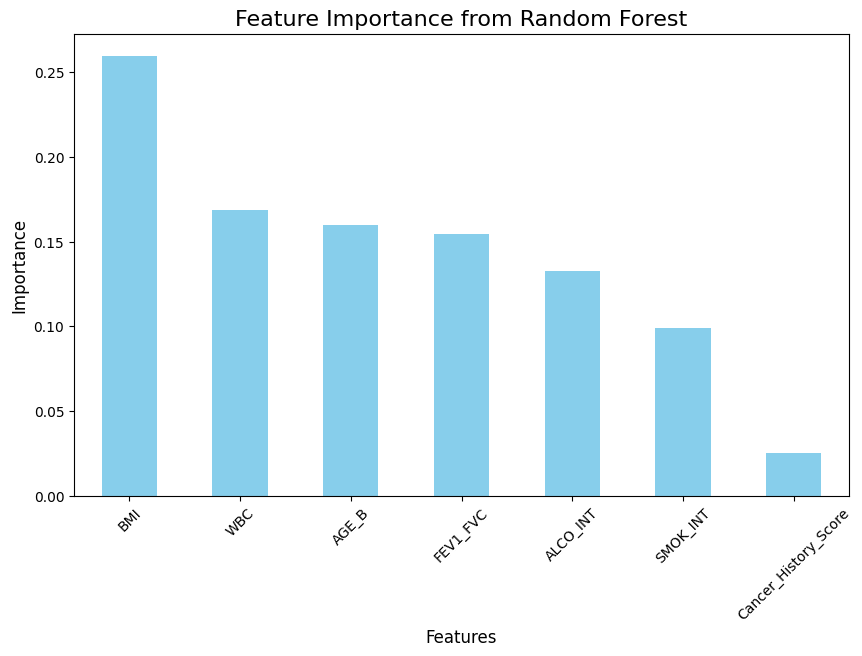

Feature Importances:
BMI                     0.259762
WBC                     0.168841
AGE_B                   0.159652
FEV1_FVC                0.154777
ALCO_INT                0.132641
SMOK_INT                0.099289
Cancer_History_Score    0.025038
dtype: float64

AUC Score: 0.7849


In [18]:
rf_model = RandomForestClassifier(random_state=7)
rf_model.fit(X_train, y_train)

# feature importance
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)

plt.figure(figsize=(10, 6))
feature_importances.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Feature Importance from Random Forest', fontsize=16)
plt.ylabel('Importance', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# prediction
y_pred_prob = rf_model.predict_proba(X_test)[:, 1]  # 확률 예측
y_pred = rf_model.predict(X_test)  # 이진 예측

# AUC
auc_score = roc_auc_score(y_test, y_pred_prob)

# result
print("Feature Importances:")
print(feature_importances.sort_values(ascending=False))
print(f"\nAUC Score: {auc_score:.4f}")

### Logistic Regression

In [24]:
# Logistic Regression
log_model = LogisticRegression(random_state=7, max_iter=100)
log_model.fit(X_train, y_train)

# Test
y_pred_prob = log_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_prob)  # AUC

# result
print(f"AUC Score: {auc_score:.4f}")

AUC Score: 0.7601


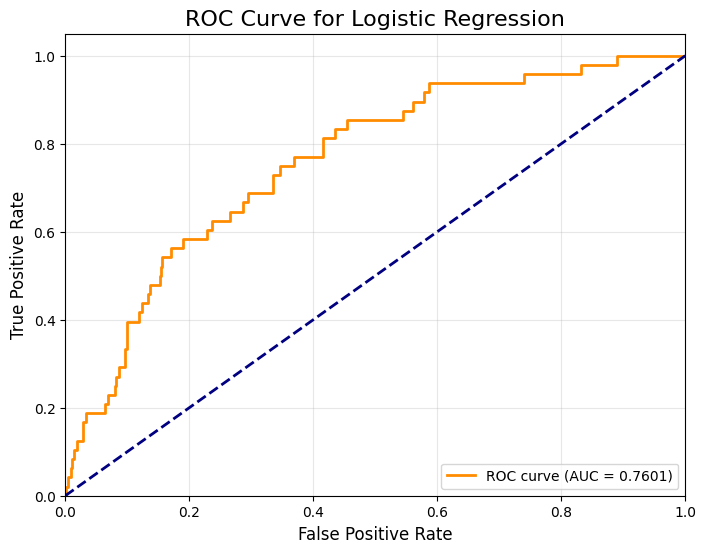

In [25]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 대각선 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve for Logistic Regression', fontsize=16)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

### Stacking Ensemble model

In [22]:
# base model
base_models = [
    ('rf', RandomForestClassifier(random_state=7)),
    ('xgb', XGBClassifier(random_state=7, use_label_encoder=False)),
    ('lgb', LGBMClassifier(random_state=7)),
    ('svc', SVC(kernel='rbf', probability=True, random_state=7))
]

# Stacking Ensemble Model
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(max_iter=1000, random_state=7),
    stack_method='predict_proba'
)

# train
stacking_model.fit(X_train, y_train)

# test
y_pred_prob = stacking_model.predict_proba(X_test)[:, 1]

# AUC
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"AUC Score: {auc_score:.4f}")

/Users/ryoonki/opt/anaconda3/envs/cancer_prediction/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:19:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 451, number of negative: 14808
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1038
[LightGBM] [Info] Number of data points in the train set: 15259, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.029556 -> initscore=-3.491456
[LightGBM] [Info] Start training from score -3.491456


/Users/ryoonki/opt/anaconda3/envs/cancer_prediction/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:19:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ryoonki/opt/anaconda3/envs/cancer_prediction/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:19:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ryoonki/opt/anaconda3/envs/cancer_prediction/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:19:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/ryoonki/opt/anaconda3/envs/cancer_prediction/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [00:19:51] WARNING: /Users/runner/work/xgboost/xgboost/src

[LightGBM] [Info] Number of positive: 361, number of negative: 11846
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 12207, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.029573 -> initscore=-3.490868
[LightGBM] [Info] Start training from score -3.490868
[LightGBM] [Info] Number of positive: 361, number of negative: 11846
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 12207, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.029573 -> initscore=-3.490868
[LightGB

##### ROC AUC Visualization

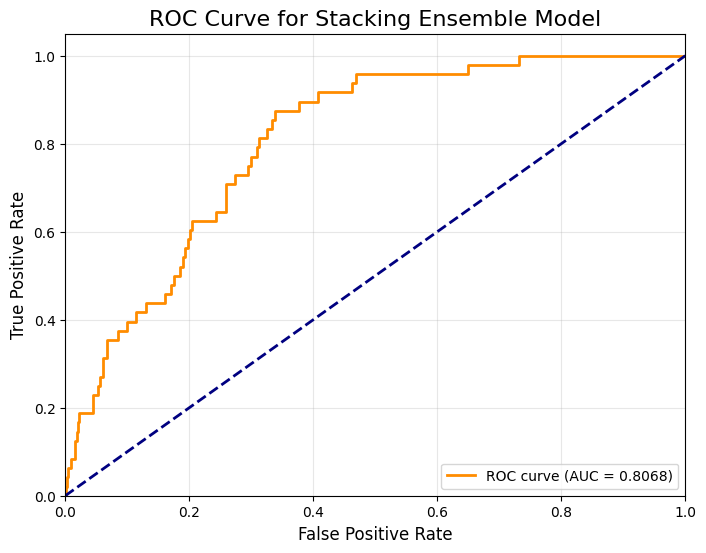

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 대각선 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve for Stacking Ensemble Model', fontsize=16)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

### Voting Classifier

In [98]:
# base model
base_models = [
    ('rf', RandomForestClassifier(random_state=7)),
    ('xgb', XGBClassifier(random_state=7, use_label_encoder=False)),
    ('lgb', LGBMClassifier(random_state=7)),
    ('svc', SVC(kernel='rbf', probability=True, random_state=7))
]

voting_clf = VotingClassifier(
    estimators=base_models,
    voting='soft'
)
voting_clf.fit(X_train, y_train)
y_pred_prob = voting_clf.predict_proba(X_test)[:, 1]

auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"AUC Score: {auc_score:.4f}")

/Users/ryoonki/opt/anaconda3/envs/cancer_prediction/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:33:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 451, number of negative: 14808
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1038
[LightGBM] [Info] Number of data points in the train set: 15259, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.029556 -> initscore=-3.491456
[LightGBM] [Info] Start training from score -3.491456
AUC Score: 0.8088


##### ROC AUC Visualization

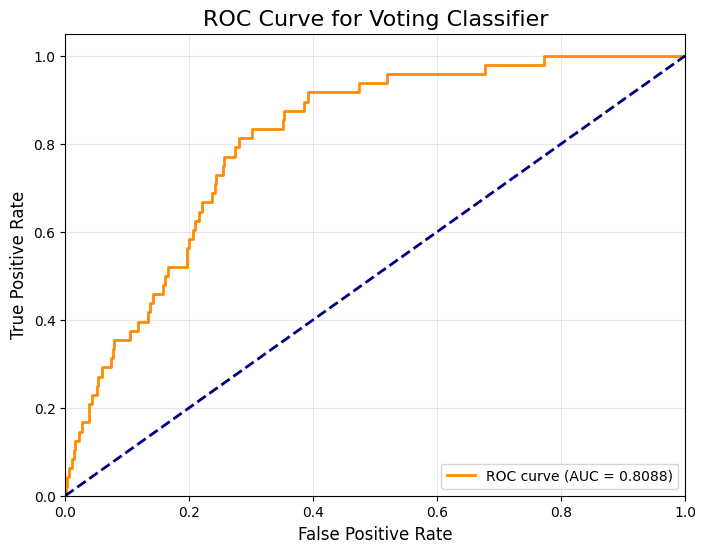

In [99]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # 대각선 기준선
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve for Voting Classifier', fontsize=16)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# 그 외 다른 시도

In [70]:
# kmeans train
kmeans = KMeans(n_clusters=2, random_state=7)
X_train['Cluster'] = kmeans.fit_predict(X_train)

# kmeans predict
X_test['Cluster'] = kmeans.predict(X_test)

# train classifier
clf = LogisticRegression(max_iter=1000, random_state=7)
clf.fit(X_train[['Cluster']], y_train)

# AUC
y_pred_prob = clf.predict_proba(X_test[['Cluster']])[:, 1]
auc_score = roc_auc_score(y_test, y_pred_prob)
print(f"AUC Score: {auc_score}")

AUC Score: 0.5929409385113268
